## <font color=indigo><u> Use Case -  Optimizing news search experience with OpenAI embeddings on the Azure platform

### <font color=brown><b> Prerequisites
- An Azure subscription 
- Python 3.7.1 or later version
- Python libraries: openai, num2words, matplotlib, plotly, scipy, scikit-learn, pandas, tiktoken.
- Jupyter Notebooks
- An Azure OpenAI resource with the text-embedding-ada-002 (Version 2) model deployed. 

### <font color=brown><b> Build framework

#### <font color=blue><b>1. Python Libraries 

In [1]:
#pip install openai 

In [2]:
#pip install num2words matplotlib plotly scipy scikit-learn pandas tiktoken

#### <font color=blue><b>2. Create Environment

##### <font color=indigo>Make a call with Azure OpenAI using endpoint and a key.
    
- Generate and allocate persistent environment variable for your key and endpoint.  
    

   


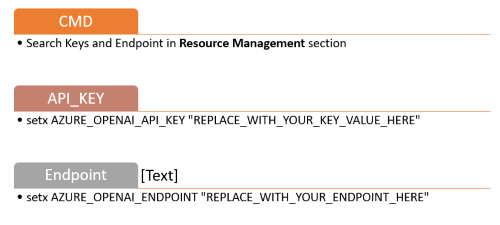

### <font color=brown><b> Import libraries and model

In [3]:
import openai
import os
import re
import requests
import sys
from num2words import num2words
import os
import pandas as pd
import numpy as np
from openai.embeddings_utils import get_embedding, cosine_similarity
import tiktoken


In [4]:

API_KEY = os.getenv("AZURE_OPENAI_API_KEY") 
RESOURCE_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT") 

openai.api_type = "azure"
openai.api_key = API_KEY
openai.api_base = RESOURCE_ENDPOINT 
openai.api_type = 'azure'
openai.api_version = "2022-12-01" #this may change in the future

url = openai.api_base + "/openai/deployments?api-version=2022-12-01"

r = requests.get(url, headers={"api-key": API_KEY}) 



In [5]:
print(r.text)

{
  "data": [
    {
      "scale_settings": {
        "scale_type": "standard"
      },
      "model": "text-embedding-ada-002",
      "owner": "organization-owner",
      "id": "Embedding_Model1",
      "status": "succeeded",
      "created_at": 1682511416,
      "updated_at": 1682511416,
      "object": "deployment"
    },
    {
      "scale_settings": {
        "scale_type": "standard"
      },
      "model": "code-davinci-002",
      "owner": "organization-owner",
      "id": "ex",
      "status": "succeeded",
      "created_at": 1682605546,
      "updated_at": 1682605546,
      "object": "deployment"
    },
    {
      "scale_settings": {
        "scale_type": "standard"
      },
      "model": "gpt-35-turbo",
      "owner": "organization-owner",
      "id": "ChatAPI",
      "status": "succeeded",
      "created_at": 1686507525,
      "updated_at": 1686507525,
      "object": "deployment"
    },
    {
      "scale_settings": {
        "scale_type": "standard"
      },
      "model

 ### <font color=brown><b> Read csv file and create a pandas DataFrame

In [6]:
df_news=pd.read_csv(os.path.join(os.getcwd(),'India_news_headline_V2.csv')) # This assumes that you have placed the India_news_headline_V1.csv in the same directory you are running Jupyter Notebooks
df_news

,publish_date,headline_category,headline_text
0,20210912,sports.tennis.us-open,Britain's Emma Raducanu; 18; beats Canada's Le...
1,20210913,sports.tennis.us-open,Tennis: De Groot claims first wheelchair golde...
2,20210913,sports.tennis.us-open,Daniil Medvedev ends Novak Djokovic's bid for ...
3,20210917,sports.cricket.icc-mens-t20-world-cup,It's official: Virat Kohli to quit as India's ...
4,20210919,sports.off-the-field,Tokyo Olympics silver medallist Ravi Kumar Dah...
...,...,...,...
259,20220319,sports.golf,Shubhankar Sharma shoots under par in both rou...
260,20220319,sports.cricket.news,India vs Australia: Mithali Raj equals record ...
261,20220319,sports.cricket.ipl,IPL 2022: Shimron Hetmyer wants to pick Kumar ...
262,20220319,sports.cricket.news,ICC Women's World Cup: West Indies' Shamilia C...


### <font color=brown><b> Perform  data cleaning by removing redundant whitespace and cleaning up the punctuation (Optional) 

In [7]:
pd.options.mode.chained_assignment = None #https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#evaluation-order-matters

# s is input text
def normalize_text(s, sep_token = " \n "):
    s = re.sub(r'\s+',  ' ', s).strip()
    s = re.sub(r". ,","",s)
    # remove all instances of multiple spaces
    s = s.replace("..",".")
    s = s.replace(". .",".")
    s = s.replace("\n", "")
    s = s.replace(";", "")
    s = s.replace("!", "")
    s = s.replace("#", "")
    s = s.strip()
    
    return s

df_news['headline_text']= df_news["headline_text"].apply(lambda x : normalize_text(x))

### <font color=brown><b> Check df_news

In [8]:
df_news.head(10)

,publish_date,headline_category,headline_text
0,20210912,sports.tennis.us-open,Britain's Emma Raducanu 18 beats Canada's Leyl...
1,20210913,sports.tennis.us-open,Tennis: De Groot claims first wheelchair golde...
2,20210913,sports.tennis.us-open,Daniil Medvedev ends Novak Djokovic's bid for ...
3,20210917,sports.cricket.icc-mens-t20-world-cup,It's official: Virat Kohli to quit as India's ...
4,20210919,sports.off-the-field,Tokyo Olympics silver medallist Ravi Kumar Dah...
5,20210920,sports.cricket.ipl,IPL 2021: Ruturaj Gaikwad and Dwayne Bravo got...
6,20210920,sports.football,Pele 'punching the air' and getting 'better ev...
7,20210920,sports.tennis,Italy's Jasmine Paolini claims maiden WTA titl...
8,20210920,sports.more-sports.athletics,You'll see a lot of success coming out of Odis...
9,20210920,sports.cricket.ipl,IPL 2021: One of my top innings says Ruturaj G...


##### <font color=brown><u>Pass the documents to the embeddings model

In [9]:
df_news['ada_02'] = df_news["headline_text"].apply(lambda x : get_embedding(x, engine = 'Embedding_Model1')) # engine should be set to the deployment name you chose when you deployed the text-embedding-ada-002 (Version 2) model

In [10]:
df_news.head()

,publish_date,headline_category,headline_text,ada_02
0,20210912,sports.tennis.us-open,Britain's Emma Raducanu 18 beats Canada's Leyl...,"[-0.020307641476392746, -0.008113071322441101,..."
1,20210913,sports.tennis.us-open,Tennis: De Groot claims first wheelchair golde...,"[-0.001497726421803236, -0.01388695277273655, ..."
2,20210913,sports.tennis.us-open,Daniil Medvedev ends Novak Djokovic's bid for ...,"[-0.02074730210006237, -0.007831976749002934, ..."
3,20210917,sports.cricket.icc-mens-t20-world-cup,It's official: Virat Kohli to quit as India's ...,"[-0.01351586077362299, -0.008026225492358208, ..."
4,20210919,sports.off-the-field,Tokyo Olympics silver medallist Ravi Kumar Dah...,"[-0.007898214273154736, 0.004959497135132551, ..."


##### <font color=brown><b>embed the search query 

In [11]:
# search through the reviews for a specific product
def search_docs(df, user_query, top_n=3, to_print=True):
    embedding = get_embedding(
        user_query,
        engine="Embedding_Model1" # engine should be set to the deployment name you chose when you deployed the text-embedding-ada-002 (Version 2) model
    )
    df["similarities"] = df.ada_02.apply(lambda x: cosine_similarity(x, embedding))

    res = (
        df.sort_values("similarities", ascending=False)
        .head(top_n)
    )
    if to_print:
        display(res)
    return res


res = search_docs(df_news, "Roy,Rana lead KKR charge", top_n=4)

,publish_date,headline_category,headline_text,ada_02,similarities
23,20210920,sports.cricket.ipl,IPL 2021: RCB eye winning start against KKR,"[-0.008443213067948818, -0.007287687622010708,...",0.870999
45,20211016,sports.cricket.ipl,IPL 2021: Extremely proud of the fight we have...,"[-0.009363598190248013, -0.021790429949760437,...",0.843397
25,20210922,sports.cricket.ipl,Punjab Kings vs Rajasthan Royals Highlights: K...,"[-0.00900831539183855, 0.0027412332128733397, ...",0.841662
62,20211105,sports.cricket.news,Syed Mushtaq Ali T20: Pandey Nair propel Karna...,"[-0.0023069882299751043, -0.005675294436514378...",0.839916


In [12]:
res["headline_text"][23]

'IPL 2021: RCB eye winning start against KKR'

In [13]:
res = search_docs(df_news, "Delhi Capitals Name Priyam Garg As Replacement For Kamlesh Nagarkoti", top_n=4)

,publish_date,headline_category,headline_text,ada_02,similarities
3,20210917,sports.cricket.icc-mens-t20-world-cup,It's official: Virat Kohli to quit as India's ...,"[-0.01351586077362299, -0.008026225492358208, ...",0.826632
149,20211107,sports.cricket.ipl,IPL 2022: Ravi Shastri likely to sign up as co...,"[-0.005485007539391518, -0.01737249083817005, ...",0.817014
156,20211108,sports.cricket.icc-mens-t20-world-cup,Knocked out of T20 World Cup time for India to...,"[0.0075756218284368515, -0.028075959533452988,...",0.815666
56,20211104,sports.cricket.new-zealand-in-india,It's official: Rahul Dravid is next Team India...,"[-0.02562318556010723, -0.006006864830851555, ...",0.814282


#### <font color=Brown> <b> Interpretation 
The top result from document search based on user query against the entire knowledge base. This returns the top result of the "sports.football.epl". This document has a cosine similarity score of 0.86 between the query and the document: